In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<ipython-input-2-eff487f01bc2>:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

# Load the files

In [7]:
files = ['../data/Chicago/full.csv', '../synth_data/Chicago/columns_order/original.csv', '../synth_data/Chicago/columns_order/best.csv']
labels = ['original', 'unshuffled', 'best']

for i in range(1,11):
    files.append('../synth_data/Chicago/columns_order/order' + str(i) + '.csv')
    labels.append('rnd' + str(i))

In [8]:
files = ['../data/Chicago/full.csv', 
         '../synth_data/Chicago/tgan_100.csv', 
         '../synth_data/Chicago/tgan_1000.csv', 
         '../synth_data/Chicago/ctgan.csv',
         '../synth_data/Chicago/ctgan_300.csv',
         '../synth_data/Chicago/ctgan_1000.csv']
labels = ['original', 'tgan - 100ep', 'tgan - 1000ep', 'ctgan - 100ep', 'ctgan - 300ep', 'ctgan - 1000ep']


In [9]:
dfs = [pd.read_csv(file) for file in files]

In [10]:
continuous_cols = ['distance', 'age', 'departure_time']

# Transform all values in numerical

In [11]:
ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
floats = ['departure_time', 'distance', 'license']

In [12]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [13]:
dct

{'travel_dow': 'int64',
 'hh_vehicles': 'int64',
 'hh_size': 'int64',
 'hh_bikes': 'int64',
 'hh_descr': 'int64',
 'hh_income': 'int64',
 'gender': 'int64',
 'education_level': 'int64',
 'age': 'int64',
 'departure_time': 'float64',
 'distance': 'float64',
 'license': 'float64'}

In [14]:
dfs = [df.astype(dct) for df in dfs]

In [15]:
choices = {}
trip_purpose = {}
work_status = {}

for c in ['choice', 'trip_purpose', 'work_status']: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):
        if c == 'choice':
            choices[n] = i
            
        if c == 'trip_purpose':
            trip_purpose[n] = i
            
        if c == 'work_status':
            work_status[n] = i
        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [16]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Compute the stats

In [17]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [18]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original)).union(set(np.unique(synthetic)))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = min(np.min(original), np.min(synthetic)) - eps
    max_val = max(np.max(original), np.max(synthetic)) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [34]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [35]:
def plot(freqs_original, freqs_synthetic, title=None):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
    
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=14)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    
    if title is not None:
        plt.title(title)

# Let's have some fun =)

In [36]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    synth_freqs.append([])

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50, c not in continuous_cols)
        
        if i == 1:
            orig_freqs.append(a)
        
        synth_freqs[i-1].append(b)

In [37]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [38]:
orig_freqs = list(flatten(orig_freqs))


for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))

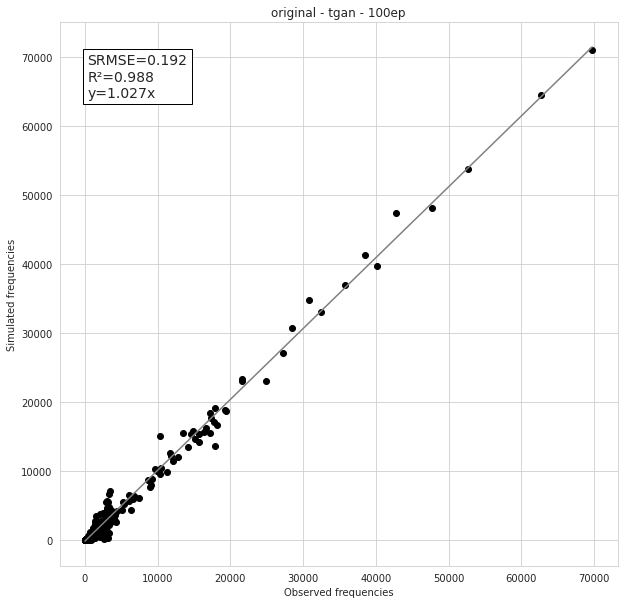

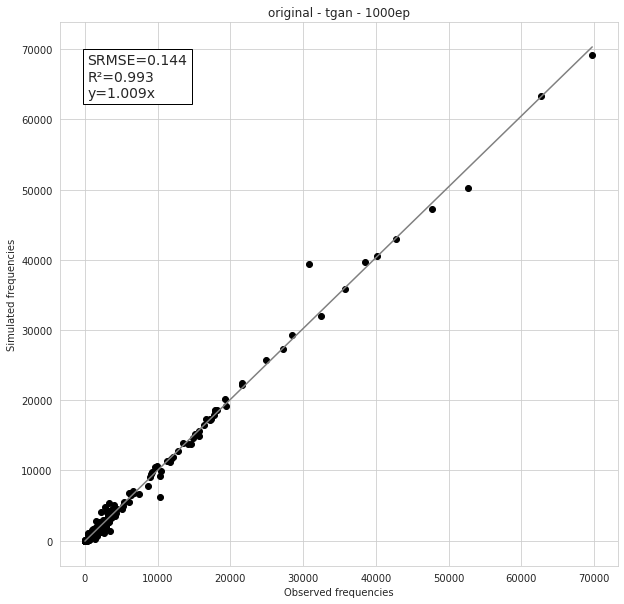

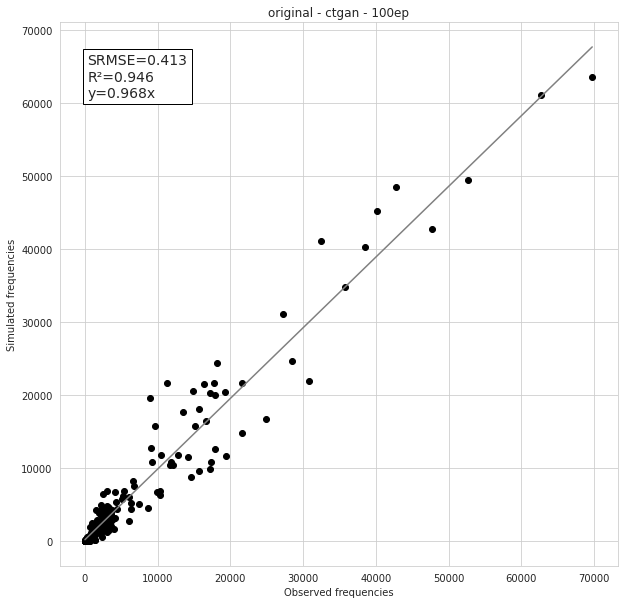

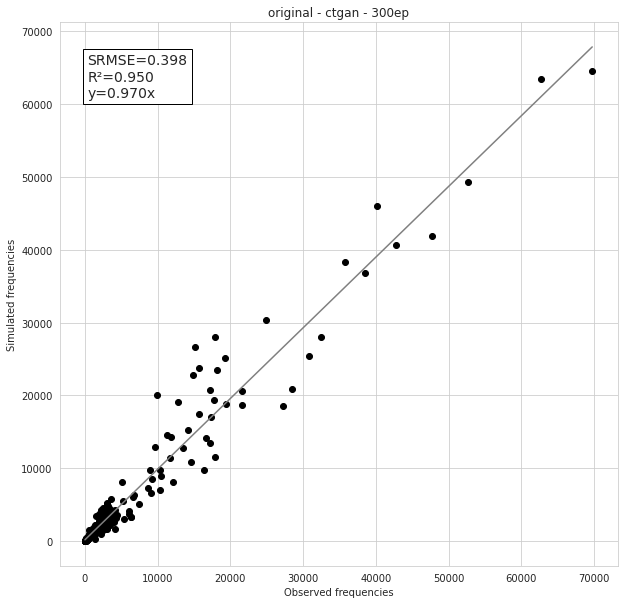

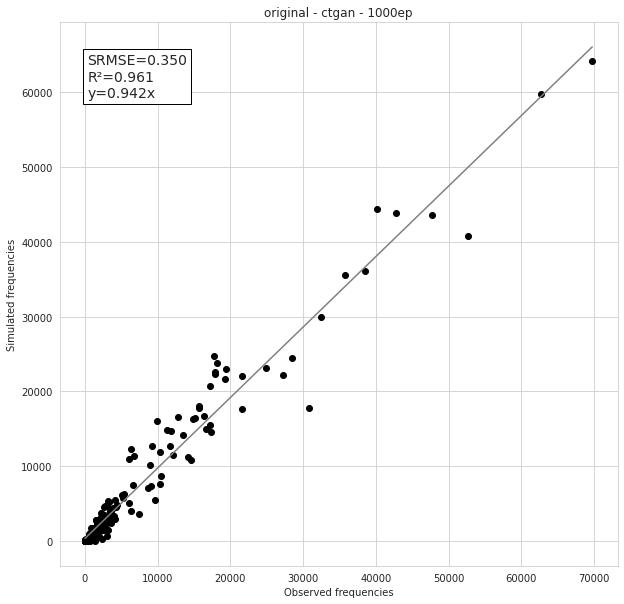

In [39]:
for i in range(len(synth_freqs)):
    plot(orig_freqs, synth_freqs[i], labels[0] + ' - ' + labels[i+1])

In [40]:
SRMSES = []

for i in range(len(dfs)-1):
    SRMSES.append([])

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50, c not in continuous_cols)
        
        stat = stats(a,b)
        
        SRMSES[i-1].append(stat['srmse'])

Averga of SRMSE
tgan - 100ep: 0.187
tgan - 1000ep: 0.135
ctgan - 100ep: 0.303
ctgan - 300ep: 0.300
ctgan - 1000ep: 0.250


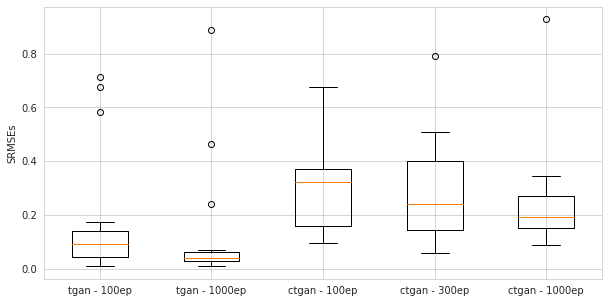

In [41]:
plt.figure(figsize=(10,5))
plt.boxplot(SRMSES)
plt.xticks(range(1,len(SRMSES)+1), labels[1:])
plt.ylabel('SRMSEs')

print("Averga of SRMSE")
for i in range(len(SRMSES)):
    print("{}: {:.3f}".format(labels[i+1], np.mean(SRMSES[i])))#*(pca_var[0]+pca_var[i+1])/2)))